<a href="https://colab.research.google.com/github/silvi-no26/c_vision/blob/main/Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Load and visualize the 'coins' image from the skimage built-in datasets. Report the size of the image and range of the pixel grayscale levels.

<ipython-input-7-fa7bd4f91b1b>:5: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(I)
<ipython-input-7-fa7bd4f91b1b>:6: FutureWarning: `show` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.show()


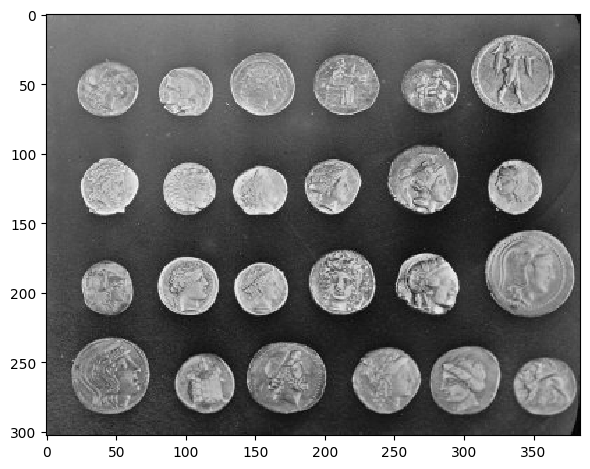

M = 384 columns, N = 303 rows
Min pixel value = 1
Max pixel value = 252


In [7]:
import skimage as sk # load skimage libraries
from skimage import data, io
I = sk.data.coins() # load a color image from the skimage built-in dataset
# Visualize the image
io.imshow(I)
io.show()

# Get image size
rows, cols = I.shape
print('M = {} columns, N = {} rows'.format(cols, rows))
# Get range of pixel grayscale levels
print('Min pixel value =', I.min())
print('Max pixel value =', I.max())

2. Represent the histogram of the image. Explain the peaks of the histogram in terms of regions of the image.

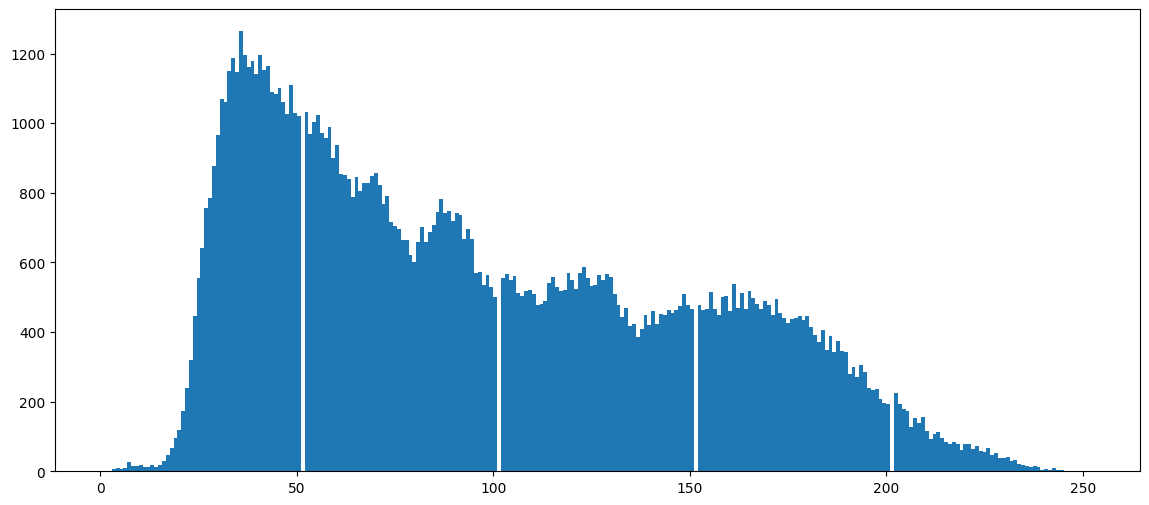

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# reshape the uint8 image as 1d array:
v = I.reshape(I.shape[0]*I.shape[1],1)

fig = plt.figure(figsize=(14, 6))
plt.hist(v, bins=256,density=False)
plt.show()

  The histogram is a good indicator to know the quality of an image. The peaks of the histogram correspond to frequently occurring intensity levels in the image. For example, in the coins image, one peak represents the background, and another represents the coin regions, making it easy to choose a threshold to segment them.
  Each peak corresponds to a dominant grayscale level. We a large number of pixels near to 0 which means that the background is dominant compared to coins.

3. Applied noise to the image and use the correct function to erase the noise.

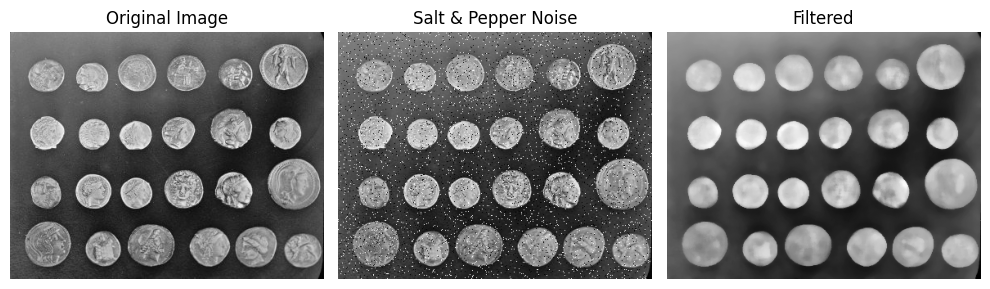

In [15]:
from skimage.util import random_noise
from skimage import img_as_ubyte
from skimage.morphology import disk
from skimage.filters import median
import matplotlib.pyplot as plt

I = sk.data.coins()
# Add salt and pepper noise
noisy_sp = random_noise(I, mode='s&p', amount=0.05)

#Apply median filter
img = img_as_ubyte(noisy_sp)
sel5 = disk(5) # structuring element disk radius 5 pixels
img_med5x5 = median(img, sel5)

# Display
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(I,  cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(noisy_sp,  cmap='gray')
axes[1].set_title('Salt & Pepper Noise')
axes[1].axis('off')

axes[2].imshow(img_med5x5,  cmap='gray')
axes[2].set_title('Filtered')
axes[2].axis('off')

plt.tight_layout()
plt.show()





4. Segment the image using a k-means clustering algorithm with k=2 and represent the result

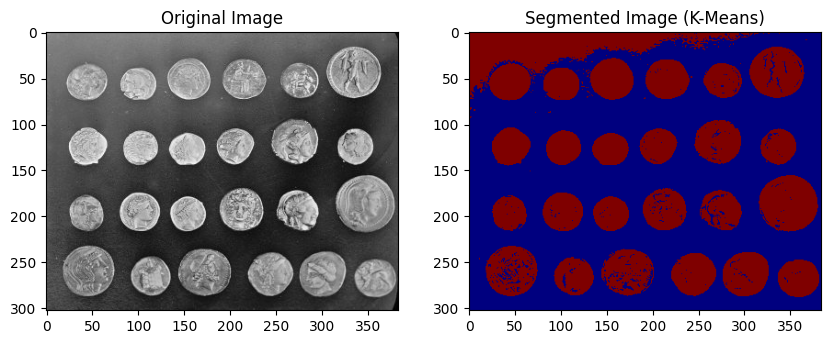

In [17]:
import numpy as np
from sklearn.cluster import KMeans

# Load the image
I = sk.data.coins()

# Convert the image to a 2D array
image_2D = I.reshape((-1, 1))

# Apply K-Means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(image_2D)
segmented_image = kmeans.labels_.reshape(I.shape[:2])

# Display results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(I, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(segmented_image, cmap=plt.cm.jet)
axes[1].set_title('Segmented Image (K-Means)')
plt.show()

5. Label the objects found in the image. Generate a figure with the original image and the labeled image. How many coins are there in the image?

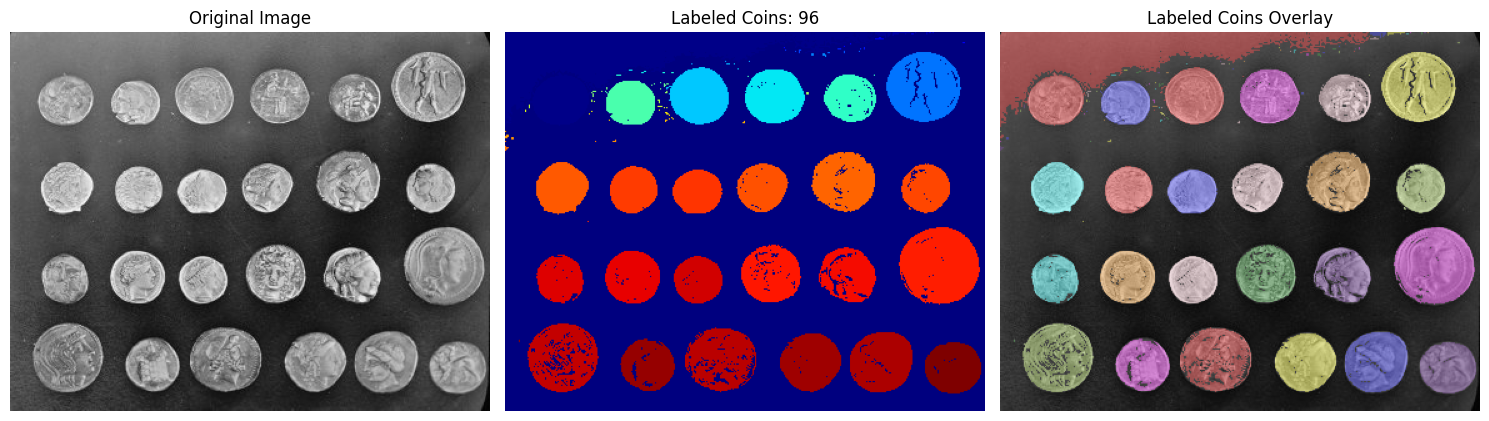

In [18]:
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.color import label2rgb

# Assume the coin cluster is the brighter one
# We find the label with the higher mean intensity
mask0 = (segmented_image == 0)
mask1 = (segmented_image == 1)
mean0 = I[mask0].mean()
mean1 = I[mask1].mean()
coin_cluster_label = 0 if mean0 > mean1 else 1

#Binary mask of coin regions
coins_mask = (segmented_image == coin_cluster_label)

# Label the objects
labeled_image, n_coins = label(coins_mask, return_num=True)
overlay = label2rgb(labeled_image, image=I, bg_label=0)

#Display
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(I, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(labeled_image, cmap='jet')
ax[1].set_title(f'Labeled Coins: {n_coins}')
ax[1].axis('off')

ax[2].imshow(overlay)
ax[2].set_title('Labeled Coins Overlay')
ax[2].axis('off')

plt.tight_layout()
plt.show()

6. Extract the area, major axis length and orientation of each coin. Report the average values of the extracted features. Represent a scatterplot of the area vs major axis length.

In [19]:
import pandas as pd
from skimage import data, measure
props = measure.regionprops_table(labeled_image,properties=['label','area','axis_major_length','orientation'])

df_features = pd.DataFrame(props)
df_features.head()

,label,area,axis_major_length,orientation
0,1,8792.0,292.106573,-1.423583
1,2,37.0,14.020584,1.524098
2,3,21.0,16.645960,-1.508404
3,4,1.0,0.000000,-0.785398
4,5,2.0,2.000000,0.000000


<Axes: xlabel='axis_major_length', ylabel='area'>

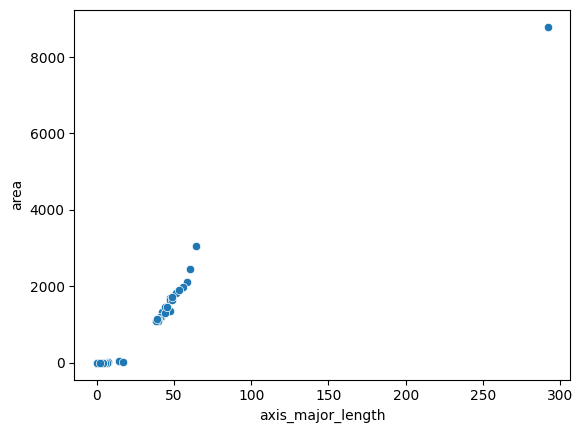

In [20]:
import seaborn as sns

sns.scatterplot(x='axis_major_length',y='area',data=df_features)

7. Using the labeled regions from the 'coins' image, how can I filter the regions to find those with an area greater than 1750 pixels, count how many such coins there are?

In [21]:
df_features.loc[df_features['area']>=1750]

,label,area,axis_major_length,orientation
0,1,8792.0,292.106573,-1.423583
22,23,2459.0,59.966495,1.552547
76,77,1836.0,51.388453,1.532671
83,84,3062.0,64.327036,1.375045
89,90,2111.0,58.136960,-1.105450
90,91,1971.0,56.055225,-1.478277
91,92,1918.0,52.847912,-0.985728


In [24]:
df_large_coins= df_features.loc[df_features['area']>=1750]
N_large = df_large_coins.shape[0]
print('there are {} coins with an area larger or equal than{}'.format(N_large,1750))

there are 7 coins with an area larger or equal than1750


In [25]:
df_small_coins= df_features.loc[df_features['area']<1750]
N_small = df_small_coins.shape[0]
print('there are {} coins with an area smaller than {}'.format(N_small,1750))

there are 89 coins with an area smaller than 1750


In [27]:
labels_small = df_small_coins['label'].values
print('labels of small coins: {}'.format(labels_small))
labels_large = df_large_coins['label'].values
print('labels of large coins: {}'.format(labels_large))


labels of small coins: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 78 79 80 81 82 83 85 86 87 88 89 93 94 95 96]
labels of large coins: [ 1 23 77 84 90 91 92]


8. Generate a 3-panel figure with the original image, the image with the little coins < 1750 coins (red color) and an image with the big coins > 1750 (blue color).

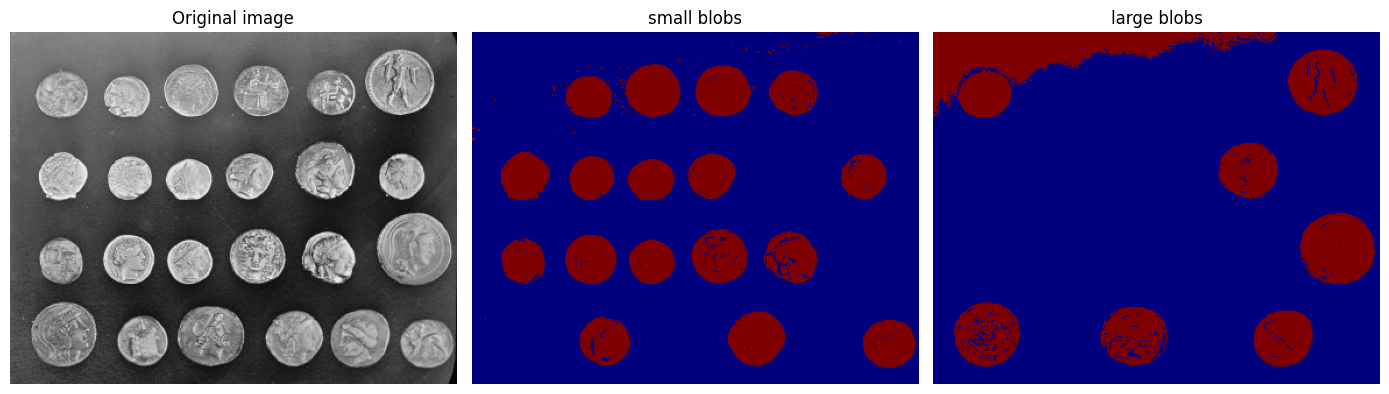

In [28]:
import numpy as np
mask_small_coins = np.isin(labeled_image,labels_small)
mask_large_coins = np.isin(labeled_image,labels_large)
# Get some figures:
fig, axes = plt.subplots(1,3,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(I,cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(mask_small_coins,cmap=plt.cm.jet)
ax[1].set_title('small blobs')
ax[2].imshow(mask_large_coins,cmap=plt.cm.jet)
ax[2].set_title('large blobs')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

9. Describe the main steps required to perform segmentation of an RGB image using an unsupervised clustering algorithm (use other algorithms different than K-Means and compare the results)

Main steps:
1-Load RGB image
2-Reshape image as N*d, where number of observations corresponds to the number of pixels of the image and the number of features corresponds to the number of color channels.
3-Apply the segmentation method.o	Fit a clustering model.
4-Predict cluster labels, Get predicted labels for each pixel
5-Reshape the result back to image size

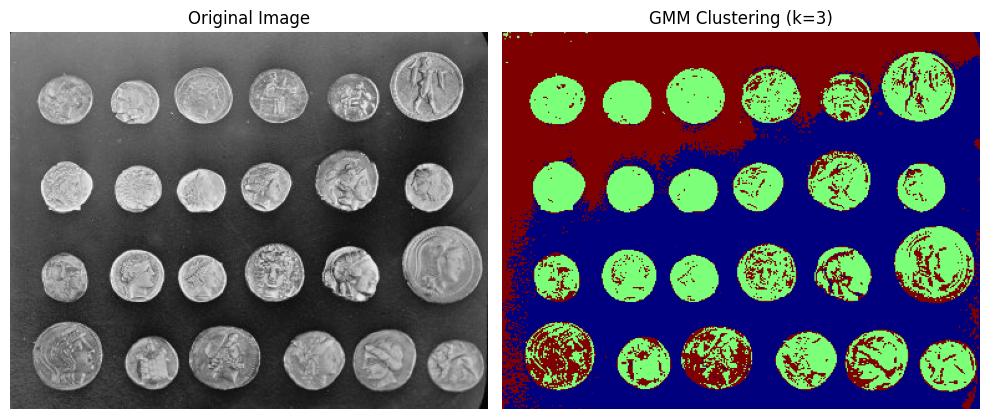

In [29]:
import skimage as sk
import numpy as np
from sklearn import mixture
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Load the grayscale image
I = sk.data.coins()

# Reshape image into 1D feature vector
v_I = I.reshape(-1, 1)

# Fit Gaussian Mixture Model with 3 components
gmm = mixture.GaussianMixture(n_components=3, random_state=0).fit(v_I)
v_gmm = gmm.predict(v_I)

# Reshape GMM labels back to image shape
I_gmm = np.reshape(v_gmm, (I.shape[0], I.shape[1]))

# Visualize original and GMM-segmented image
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, 2)

ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(I, cmap='gray')
ax0.set_title('Original Image')
ax0.axis('off')

ax1 = fig.add_subplot(gs[0, 1])
ax1.imshow(I_gmm, cmap='jet')
ax1.set_title('GMM Clustering (k=3)')
ax1.axis('off')

plt.tight_layout()
plt.show()

We see that with GMM we dont get a better result compared to k-means in this case the best is to use k-means.

10. Extract the main texture features of this image

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from skimage.feature.texture import graycomatrix, graycoprops
from skimage.measure import regionprops
from skimage import data, img_as_ubyte

# Assume that `label_image` and `IG` are already defined
# IG should be a grayscale image of type uint8
# label_image is the label map of regions


IG = img_as_ubyte(I)
props = regionprops(labeled_image,intensity_image=IG) # Obtain again the properties after removal of spourious regions

nregions = len(props)

iregion = 0
props_texture = np.zeros((nregions,5))
for i, p in enumerate(props):
    minr, minc, maxr, maxc = p.bbox
    I = IG[minr:maxr, minc:maxc]

    # Convertir a uint8 y escalar valores si es necesario
    Iu8 = img_as_ubyte(I)

    # Calculate GLCM
    g = graycomatrix(Iu8, distances=[1], angles=[0], levels=256, normed=True, symmetric=True)

    # Extract properties
    props_texture[i, 0] = graycoprops(g, 'contrast')[0, 0]
    props_texture[i, 1] = graycoprops(g, 'dissimilarity')[0, 0]
    props_texture[i, 2] = graycoprops(g, 'homogeneity')[0, 0]
    props_texture[i, 3] = graycoprops(g, 'energy')[0, 0]
    props_texture[i, 4] = graycoprops(g, 'correlation')[0, 0]


# Export to Excel file
df = pd.DataFrame(props_texture, columns=['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation'])
df.to_excel("Texture_features.xlsx", index=False)
df

,Contrast,Dissimilarity,Homogeneity,Energy,Correlation
0,254.474130,7.573417,0.310996,0.033827,0.890400
1,7.050000,1.716667,0.551310,0.206828,0.408660
2,2.461538,0.974359,0.642464,0.270145,0.887256
3,0.000000,0.000000,0.000000,0.000000,1.000000
4,0.000000,0.000000,0.000000,0.000000,1.000000
...,...,...,...,...,...
91,329.792092,11.480017,0.121271,0.022586,0.905886
92,428.130762,13.391401,0.106752,0.022048,0.920394
93,740.002769,17.286268,0.094242,0.021456,0.867842
94,0.000000,0.000000,0.000000,0.000000,1.000000


# Personal discussion
This course was very interesting for me, I liked it very much. The professor made it easy and practical to be understood.